# Nyquist Pulses

* Nyquist pulses may be longer than a symbol period
* they avoid intersymbol interference (ISI) when they satisfy the Nyquist condition:
$$
    p(nT) = \begin{cases}
    1 & \text{for $n=0$}\\
    0 & \text{for $n \neq 0$}
    \end{cases}
$$
  - Note that this condition must be met by the combination of pulse-shaping filter and matched filter, i.e., $p(t) * p(-t)$.
* Nyquist pulses are strictly bandlimited
  - their power spectra are equal to zero for some $|f| > (1+a) \frac{1}{2T}$.
    + $a$ is called the **Excess Bandwidth** or, sometimes, the *roll-off factor*
  - when pulses are truncated to some finite duration, the resulting pulse is no longer strictly bandlimited
  - however, their power spectral density is still excellent.
* The most prominent of the Nyquist pulses is the *Raised Cosine Pulse*
  - the raised cosine pulse is obtained by convolving the *square-root raised cosine* (SRRC) pulse with itself.
  - this happens when the SRRC pulse is used for both pulse-shaping and as the matched filter

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

## The Square-Root Raised Cosine (SRRC) Pulse

* The SRRC pulse is given by:
$$
h_{SRRC}(t) = \begin{cases}
 \dfrac{1}{T} \left( 1 + a(\dfrac{4}{\pi}-1) \right),
       & t = 0 \\

\dfrac{a}{T \sqrt{2}}
\left[
\left(1+\dfrac{2}{\pi}\right)\sin\left(\dfrac{\pi}{4a}\right) +
\left(1-\dfrac{2}{\pi}\right)\cos\left(\dfrac{\pi}{4a}\right)
\right],
       & t = \pm \dfrac{T}{4a} \\

\dfrac{1}{T} \dfrac{\sin\left[\pi \dfrac{t}{T}\left(1-a\right)\right] + 4a\dfrac{t}{T}\cos\left[\pi\dfrac{t}{T}\left(1+a\right)\right]}{\pi \dfrac{t}{T}\left[1-\left(4a\dfrac{t}{T} \right)^2 \right]},
       & \text{otherwise}
\end{cases}
$$
* Note, in the time-domain this pulse "rolls off" like $1/t^2$, except when $a=0$.
  - For $a=0$, the SRRC pulse is a sinc-pulse
* The conditions for $t=0$ and $t=\frac{T}{4a}$ can be computed via L'Hospital's rule.
* The function below computes a SRRC pulse truncated to $\pm NT$.

In [48]:
def srrc_pulse(a, fsT, fs=1, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a: roll-off factor
    fsT: number of samples per symbol period
    fs: sampling rate (default: 1)
    N: lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/fs
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    T = fsT/fs

    if a == 0:
        return np.sinc(tt/T)
    
    num = np.sin(np.pi*tt/T*(1-a)) + 4*a*tt*np.cos(np.pi*tt/T*(1+a))
    den = np.pi*tt/T*(1-(4*a*tt/T)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-T/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - T/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling:
    hh = 1/T * num/den
    
    return hh

### SRRC in the time domain

In [3]:
# set parameters
fs = 128
T = 1
fsT = int(fs*T)
N = 5
a = 0.5




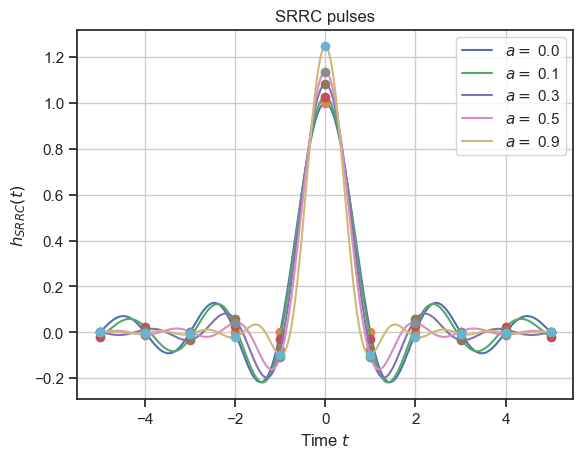

In [4]:
# time grid
tt = np.linspace(-N, N, 2*N*fsT + 1)

for a in [0, 0.1, 0.3, 0.5, 0.9]:
    p_srrc = srrc_pulse(a, fsT, fs, N)
    # plot
    plt.plot(tt, p_srrc, label=f"$a=${a:4.1f}")
    plt.plot(tt[0::fsT], p_srrc[0::fsT], 'o')

plt.xlabel('Time $t$')
plt.ylabel('$h_{SRRC}(t)$')
plt.grid()

plt.legend()
plt.title(rf"SRRC pulses" )

plt.show()

* **Note:** the SRRC pulses are **NOT**  Nyquist pulses.
  - zeros do not occur at integer multiples of the symbol period $T$.

## The Raised Cosine (RC) Pulse

* The raised cosine pulse results when an SRRC pulse is convolved with itself
   - $p_{RC}(t) = p_{SRRC}(t) * p_{SRRC}(-t)$
* The raised cosine pulse is given by 
$$
    h_{RC}(t)  = \text{sinc}(\pi \frac{t}{T}) \cdot \frac{\cos(\pi a t/T)}{1-(2at/T)^2}.
$$
   - note that for $a=0$, the RC pulse equals a sinc-pulse.
* The function below computes an RC pulse with roll-off factor

In [5]:
def rc_pulse(a, fsT, fs=1, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a: roll-off factor
    fsT: number of samples per symbol period
    fs: sample rate (default: 1)
    N: lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)

    if a == 0:
        return np.sinc(tt)
    
    if np.min(np.abs(tt - 1/(2*a))) > 1e-6:
        # fast if there is no divide by zero
        return np.sinc(tt) * np.cos(np.pi*a*tt)/(1-(2*a*tt)**2)
    else:
        # deal with the case when 1-(2*a*tt)**2 = 0
        ss = np.sinc(tt)
        ind_0 = np.where(np.abs(np.abs(tt) - 1/(2*a)) < 1e-6)
        tt[ind_0] = 0
        bb = np.cos(np.pi*a*tt)/(1-(2*a*tt)**2)
        bb[ind_0] = np.pi/4

        return ss * bb

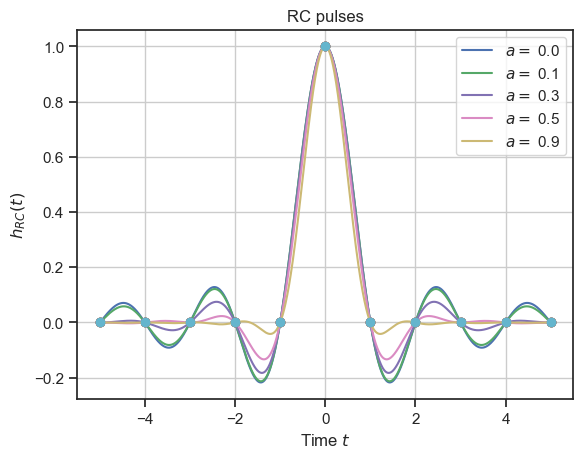

In [6]:
# time grid
tt = np.linspace(-N, N, 2*N*fsT + 1)

for a in [0, 0.1, 0.3, 0.5, 0.9]:
    p_rc = rc_pulse(a, fsT, fs, N)
    # plot
    plt.plot(tt, p_rc, label=f"$a=${a:4.1f}")
    plt.plot(tt[0::fsT], p_rc[0::fsT], 'o')

plt.xlabel('Time $t$')
plt.ylabel('$h_{RC}(t)$')
plt.grid()

plt.legend()
plt.title(rf"RC pulses" )

plt.show()

The RC pulses **ARE** Nyquist pulses.

#### Verify that $h_{RC}(t) = h_{SRRC}(t) * h_{SRRC}(-t)$

* To verify that that the RC pulses is equal to the result of convolving a SRRC pulse with itself.
  - construct a SRRC pulse truncated at $\pm 5T$
     + convolve that pulse with itself
     + the resulting pulse will be twice as long, i.e., for $-10T$ to $10T$
  - construct a RC pulse truncated at $\pm 10T$
  - plot both pulses for comparison
    + they should overlap completely

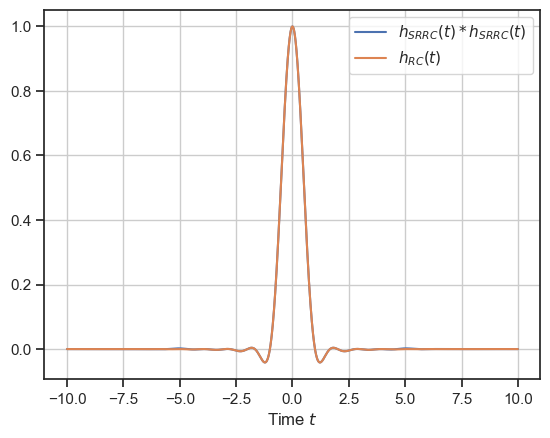

In [7]:
# SRRC pulse
h_SRRC = srrc_pulse(a, fsT, fs, N=5)

# convolve with itself - time reversal not needed because of symmetry
h_conv = np.convolve(h_SRRC, h_SRRC) / fs   # divide by fs to approximate continuous-time convolution

# RC pulse
h_RC = rc_pulse(a, fsT, fs, 10)
tt = np.linspace(-10, 10, 2*10*fsT+1)

## plot
plt.plot(tt, h_conv, label="$h_{SRRC}(t) * h_{SRRC}(t)$")
plt.plot(tt, h_RC, label="$h_{RC}(t)$")

plt.grid()
plt.xlabel('Time $t$')

plt.legend()

plt.show()

* **Note:** the convolution of a RC pulse with itself is **not** a Nyquist pulse.
  - it is not well suited for pulse-shaping

## Spectrum

* The SRRC pulse is used for pulse shaping.
* The PSD of the transmitted signal is given by:
$$
S(f) = \dfrac{E_s}{T} |P_{SRRC}(f)|^2.
$$
    - where $P_{SRRC}(f)$ denotes the Fourier transform of the SRRC pulse $h_{SRRC}(t)$
* Since $h_{SRRC}(t) * h_{SRRC}(-t) = h_{RC}(t)$, it follows that 
$$
    |P_{SRRC}(f)|^2 = |P_{RC}(f)|.
$$
  - where $P_{RC}(f)$ is the Fourier transform of the RC pulse $h_{RC}(t)$
  - this is where the "square-root" in SRRC comes from

### Fourier transform of RC pulse

* The RC pulse, $h_{RC}(t)$ has a relatively simple Fourier transform:
$$
P_{RC}(f) = \begin{cases}
 1,
       & |f| \leq \frac{1 - a}{2T} \\
 \frac{1}{2}\left[1 + \cos\left(\frac{\pi T}{a}\left[|f| - \frac{1 - a}{2T}\right]\right)\right],
       & \frac{1 - a}{2T} < |f| \leq \frac{1 + a}{2T} \\
 0,
       & \text{otherwise}
\end{cases}
$$

In [8]:
def FT_RC_pulse(ff, T, a):
    """Fourier transform of the RC pulse
    
    Inputs:
    -------
    ff: vector of frequency points
    T: symbol period
    a: roll-off factor

    Returns:
    vector of the same length as ff
    """

    HH = np.zeros_like(ff)
    HH[np.abs(ff) <= 0.5*(1-a)/T]  = 1

    if a == 0:
        return HH
    
    ind = np.abs(2*T*np.abs(ff) - 1) <= a
    HH[ind] = 0.5*(1 + np.cos(np.pi*T/a * (np.abs(ff[ind]) - 0.5*(1-a)/T)))

    return HH

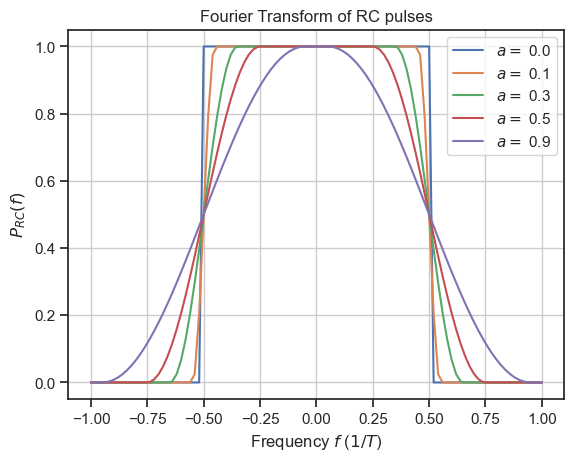

In [9]:
ff = np.linspace(-1, 1, 101)
PP = FT_RC_pulse(ff, 1, 0.5)

for a in [0, 0.1, 0.3, 0.5, 0.9]:
    PP_rc = FT_RC_pulse(ff, T, a)
    # plot
    plt.plot(ff, PP_rc, label=f"$a=${a:4.1f}")

plt.xlabel('Frequency $f$ ($1/T$)')
plt.ylabel('$P_{RC}(f)$')
plt.grid()

plt.legend()
plt.title(rf"Fourier Transform of RC pulses" )

plt.show()

**Note:** This is also the PSD of the transmitted signal when SRRC pulses are transmitted.

### Spectrum of Truncated Pulses

* The above spectra are ideal and assume that the pulses used for pulse shaping are infinitely long.
* In practice, pulses must be truncated to a finite length.
  - we will assume that the pulses are truncated to be zero outside $-NT \leq t \leq NT$.
  - Truncation is equivalent to multiplying in the frequency domain with a rectangular window from $-NT$ to $NT$
* Then, the PSD of the transmitted signal will be proportional to 
$$
    P_{ideal}(f) * 2NT \cdot \text{sinc}{\pi f 2NT}
$$
* Instead of using this convolution, we compute the spectrum of the transmitted signal numerically.

In [10]:
# import numerical FT function
from comms.pulse_shaping import numerical_FT, sine_squared_pulse

/var/folders/zw/1527vjzj6h76ccrkys88lsqr0000gp/T/ipykernel_26478/816502956.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ff, 20*np.log10(np.abs(FT_RC_pulse(ff, 1, 0.5))), label="not truncated")
/var/folders/zw/1527vjzj6h76ccrkys88lsqr0000gp/T/ipykernel_26478/816502956.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ff, 20*np.log10(np.abs(P_ss)), label=f"sine-squared")


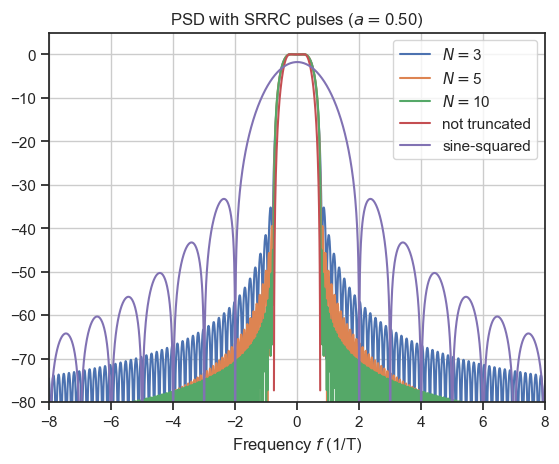

In [26]:
## plot spectrum for differently truncated pulses
fs = 32
T = 1
fsT = int(fs*T)

a = 0.5    # roll-off factor

ff = np.linspace(-fs/2, fs/2, 4096)

for N in [3, 5, 10]:
    pp = srrc_pulse(0.5, fsT, fs, N)
    PP = numerical_FT(pp, fs, 4096)

    plt.plot(ff, 20*np.log10(np.abs(PP)), label=f"$N=${N}")

plt.plot(ff, 20*np.log10(np.abs(FT_RC_pulse(ff, 1, 0.5))), label="not truncated")

# plot spectrum with sine-squared pulse for comparison
p_ss = sine_squared_pulse(fsT, fs)
P_ss = numerical_FT(p_ss, fs, 4096)
plt.plot(ff, 20*np.log10(np.abs(P_ss)), label=f"sine-squared")

plt.grid()
plt.xlabel('Frequency $f$ (1/T)')
plt.legend()

plt.xlim(-fs/4, fs/4)
plt.ylim(-80, 5)

plt.title(f'PSD with SRRC pulses ($a=${a:4.2f})')

plt.show()


## Signal with SRRC pulse-shaping

* We conclude by considering the time-domain signal that arises when a signal is pulse-shaped using SRRC pulses

In [12]:
# load functions from the tool box
from comms.mod_mapping import mod_mapper, PAM4, BPSK, demodulator
from comms.sources import string_sink, string_source
from comms.pulse_shaping import pulse_shape

In [40]:
# make a signal
fs = 128 # high sampling rate for smooth plots
T = 1
fsT = int(fs*T)
N_trunc = 10

# roll-off factor
a = 0.5  

pp = srrc_pulse(a, fsT, fsT, N_trunc)

# transmitter - using BPSK symbols
bits = string_source('Now is the time for all good men ...')
syms = mod_mapper(bits, BPSK)
sig = pulse_shape(syms, pp, fsT)

# channel
n_pwr = 0 # no noise to see if there is any ISI      # fsT/100  # 20dB SNR
r_sig = sig.real + np.sqrt(n_pwr) * np.random.randn(len(sig))

# receiver
mf_out = np.real( np.convolve(r_sig, pp)/fsT )
rx_syms = mf_out[2*N_trunc*fsT:-2*N_trunc*fsT:fsT]
rx_bits = demodulator(rx_syms, BPSK)

print('Received message:', string_sink(rx_bits))

Received message: Now is the time for all good men ...


### Matched Filter Output

* The plot below shows the matched filter output
  - samples at the sampling instances are marked with dots
  - the markers are all at $\pm 1$
    + there is no ISI
  - there is a long transient before the first sample
    + this delay is due to the combined delay of the (causal) pulse-shaping filter and the matched filter
    + each filter contributes a delay of $5T$, 
    + since the pulse is truncated at $\pm 5T$
  - note that there is significant variation between the signal trajectories away from the sampling instances
    + the signal away from the sampling instances depend of the prior and next 5 symbols

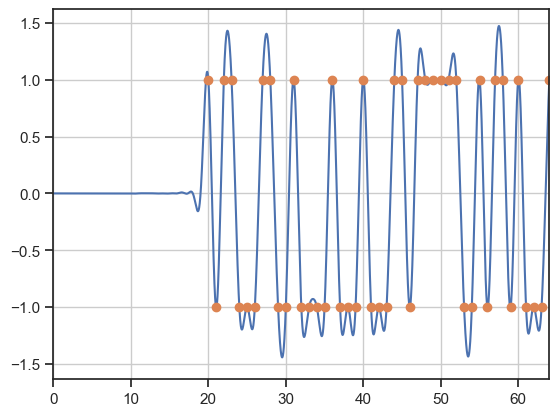

In [41]:
## plot the beginning of the received signal
tt = np.arange(len(mf_out))/fsT
plt.plot(tt, mf_out.real)
plt.plot(tt[2*N_trunc*fsT:-2*N_trunc*fsT:fsT], rx_syms, 'o')
plt.grid()
plt.xlim(0, 64)
plt.show()

### Eye Diagram

* The eye diagram shows consecutive periods of length $2T$ plotted on top of each other
  - sampling instances are at $t=1$ as well as $t=0$ and $t=2$
* Focusing on the height of the opening at $t=1$:
  - the height opening is 2
  - since all signal traces go through the symbol values
* If the signal had been sampled at $t=1.1$ (red dashed line):
  - e.g., because of a synchronization error
  - the hight of the opening is only about 1.6
  - such a timing error would increase the probability of error

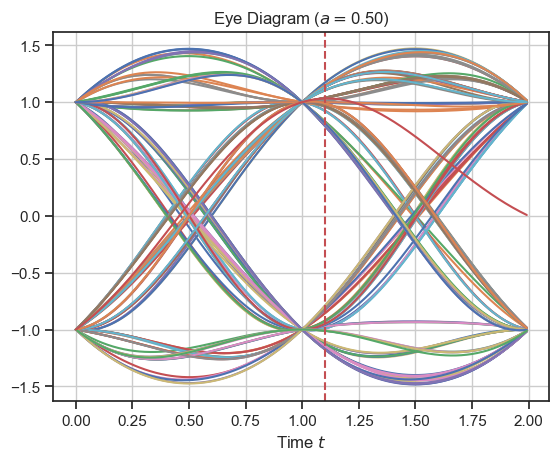

In [42]:
## Eye diagram
# plot consecutive 2T matched filter outputs on top of each other
tt = np.arange(2*fsT)/fsT
for n in np.arange(len(syms)//2):
    plt.plot(tt, mf_out[2*(n+N_trunc)*fsT : 2*(n+N_trunc+1)*fsT])

plt.xlabel('Time $t$')
plt.title(f'Eye Diagram ($a=${a:4.2f})')

plt.axvline(1.1, color='r', ls='--')

plt.grid()

### Eye Diagram for the sinc pulse

* When the roll-off factor is near zero (i.e., close to a sinc pulse):
  - overshoot and undershoot between sampling instances becomes more pronounced
  - equivalently the "eye" in the eye-diagram becomes narrower
  

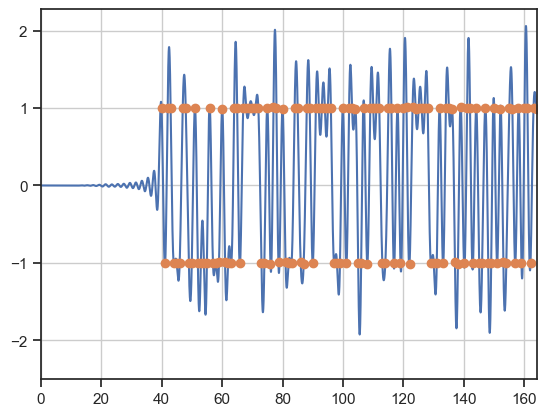

In [62]:
# make a signal
fs = 128 # high sampling rate for smooth plots
T = 1
fsT = int(fs*T)
N_trunc = 20

# roll-off factor
a = 0.05   # <--- nearly a sinc pulse truncated at 50T

pp = srrc_pulse(a, fsT, fsT, N_trunc)

# transmitter - using BPSK symbols
# make an alternating sequence of bits - this creates worst case ISI in the center
bits = np.zeros(101, dtype=np.uint8)
bits[1::2] = 1
bits[50] = 0
bits = string_source('Now is the time for all good men ...')

syms = mod_mapper(bits, BPSK)
sig = pulse_shape(syms, pp, fsT)

# channel
n_pwr = 0 # no noise to see if there is any ISI      # fsT/100  # 20dB SNR
r_sig = sig.real + np.sqrt(n_pwr) * np.random.randn(len(sig))

# receiver
mf_out = np.real( np.convolve(r_sig, pp)/fsT )
rx_syms = mf_out[2*N_trunc*fsT:-2*N_trunc*fsT:fsT]
rx_bits = demodulator(rx_syms, BPSK)

## plot the beginning of the received signal
tt = np.arange(len(mf_out))/fsT
plt.plot(tt, mf_out.real)
plt.plot(tt[2*N_trunc*fsT:-2*N_trunc*fsT:fsT], rx_syms, 'o')
plt.grid()
plt.xlim(0, 164)
plt.show()

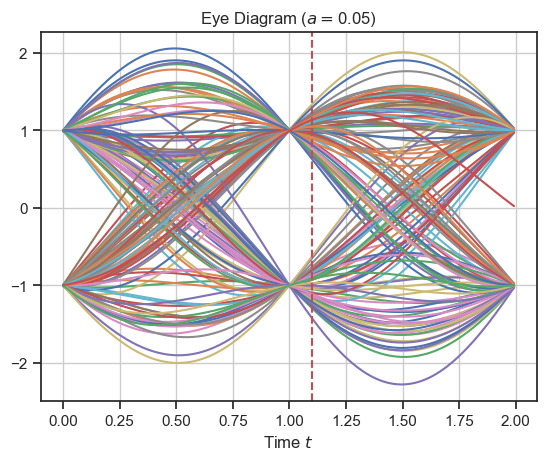

In [63]:
## Eye diagram
# plot consecutive 2T matched filter outputs on top of each other
tt = np.arange(2*fsT)/fsT
for n in np.arange(len(syms)//2):
    plt.plot(tt, mf_out[2*(n+N_trunc)*fsT : 2*(n+N_trunc+1)*fsT])

plt.xlabel('Time $t$')
plt.title(f'Eye Diagram ($a=${a:4.2f})')

plt.axvline(1.1, color='r', ls='--')

plt.grid()

from 